In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
import math
import xgboost 
import joblib
import time
from utils import *

In [2]:
pd.set_option('display.max_columns', None) # show all columns of a data frame

In [3]:
parent_dir = os.path.dirname(os.getcwd())
train_file = os.path.join(parent_dir, 'CMAPSS_Data', 'train_FD001.txt')
test_file = os.path.join(parent_dir, 'CMAPSS_Data', 'test_FD001.txt')
rul_file = os.path.join(parent_dir, 'CMAPSS_Data','RUL_FD001.txt')
weight_path = os.path.join(parent_dir, 'weights')

In [4]:
raw_train_df = pd.read_csv(train_file, sep=r"\s+", header=None)
raw_test_df = pd.read_csv(test_file, sep=r"\s+", header=None)
print(raw_train_df.shape)
print(raw_test_df.shape)

(20631, 26)
(13096, 26)


In [5]:
columns = ['unit_number','time_in_cycles','op_set_1','op_set_2','op_set_3','sm_1','sm_2','sm_3','sm_4','sm_5','sm_6','sm_7',
           'sm_8','sm_9','sm_10','sm_11','sm_12','sm_13','sm_14','sm_15','sm_16','sm_17','sm_18','sm_19','sm_20','sm_21']
raw_train_df.columns = columns
raw_test_df.columns = columns

In [6]:
raw_train_df.head()

,unit_number,time_in_cycles,op_set_1,op_set_2,op_set_3,sm_1,sm_2,sm_3,sm_4,sm_5,sm_6,sm_7,sm_8,sm_9,sm_10,sm_11,sm_12,sm_13,sm_14,sm_15,sm_16,sm_17,sm_18,sm_19,sm_20,sm_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


### Prepare train and test dataset

In [7]:
unit_number_train = pd.DataFrame({'unit_number' : raw_train_df['unit_number']})
unit_number_test = pd.DataFrame({'unit_number' : raw_test_df['unit_number']})

In [8]:
unit_number_train.head()

,unit_number
0,1
1,1
2,1
3,1
4,1


In [9]:
train_df = prepare_train_dataset(raw_train_df)
print(train_df.shape)
train_df.head()

(20631, 16)


,time_in_cycles,sm_2,sm_3,sm_4,sm_6,sm_7,sm_8,sm_9,sm_11,sm_12,sm_13,sm_15,sm_17,sm_20,sm_21,rul
0,1,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,191
1,2,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,190
2,3,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,189
3,4,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,188
4,5,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,187


In [10]:
test_df = prepare_test_dataset(raw_test_df)
print(test_df.shape)
test_df.head()

(100, 15)


,time_in_cycles,sm_2,sm_3,sm_4,sm_6,sm_7,sm_8,sm_9,sm_11,sm_12,sm_13,sm_15,sm_17,sm_20,sm_21
0,31,642.58,1581.22,1398.91,21.61,554.42,2388.08,9056.40,47.23,521.79,2388.06,8.4024,393,38.81,23.3552
1,49,642.55,1586.59,1410.83,21.61,553.52,2388.10,9044.77,47.67,521.74,2388.09,8.4505,391,38.81,23.2618
2,126,642.88,1589.75,1418.89,21.61,552.59,2388.16,9049.26,47.88,520.83,2388.14,8.4119,395,38.93,23.2740
3,106,642.78,1594.53,1406.88,21.61,552.64,2388.13,9051.30,47.65,521.88,2388.11,8.4634,395,38.58,23.2581
4,98,642.27,1589.94,1419.36,21.61,553.29,2388.10,9053.99,47.46,521.00,2388.15,8.4362,394,38.75,23.4117


In [12]:
features = train_df.columns[:-1]

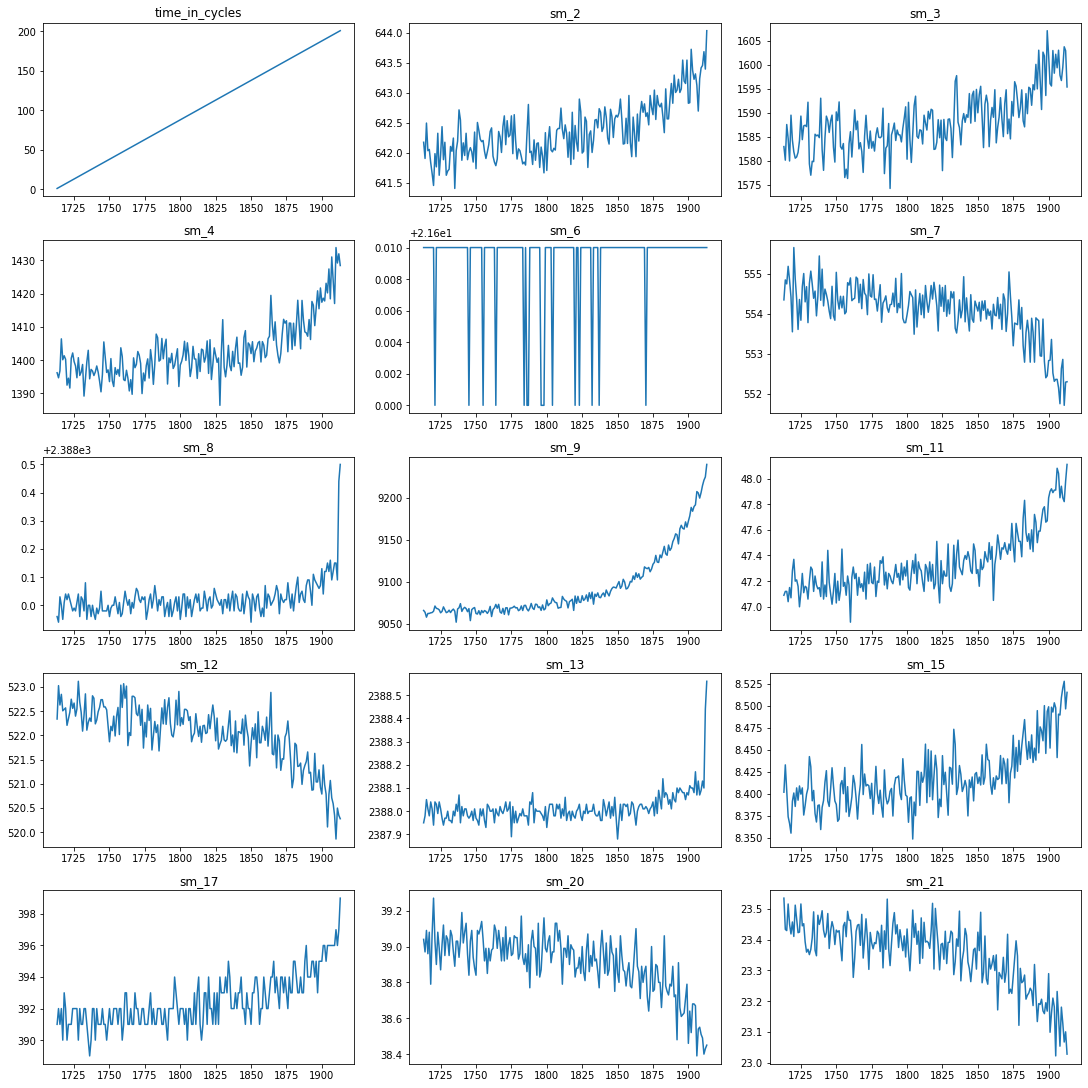

In [13]:
plot_signals(pd.concat([unit_number_train, train_df], axis=1), features, 9)

### Noise removal 

In [14]:
def smooth_dataset(data, M_ID_index, features, window_size):
    df = data.copy()
    df = pd.concat([M_ID_index, df], axis=1)
    for feature in features:
        smoothed_feature = df.groupby('unit_number')[feature].rolling(window_size).mean().reset_index()
        df[feature] = smoothed_feature[feature]
    
    df.drop(columns=['unit_number'], inplace=True)
    df.fillna(method='bfill', inplace=True)
    return df

In [15]:
window_size = 5
noisy_features = train_df.columns[1:-1]
print(noisy_features)

Index(['sm_2', 'sm_3', 'sm_4', 'sm_6', 'sm_7', 'sm_8', 'sm_9', 'sm_11',
       'sm_12', 'sm_13', 'sm_15', 'sm_17', 'sm_20', 'sm_21'],
      dtype='object')


In [16]:
smooth_train_df = smooth_dataset(train_df, unit_number_train, noisy_features, window_size=window_size)
smooth_train_df.head()

,time_in_cycles,sm_2,sm_3,sm_4,sm_6,sm_7,sm_8,sm_9,sm_11,sm_12,sm_13,sm_15,sm_17,sm_20,sm_21,rul
0,1,642.208,1587.03,1403.206,21.61,554.164,2388.07,9049.566,47.328,522.282,2388.048,8.41334,391.8,38.958,23.39302,191
1,2,642.208,1587.03,1403.206,21.61,554.164,2388.07,9049.566,47.328,522.282,2388.048,8.41334,391.8,38.958,23.39302,190
2,3,642.208,1587.03,1403.206,21.61,554.164,2388.07,9049.566,47.328,522.282,2388.048,8.41334,391.8,38.958,23.39302,189
3,4,642.208,1587.03,1403.206,21.61,554.164,2388.07,9049.566,47.328,522.282,2388.048,8.41334,391.8,38.958,23.39302,188
4,5,642.208,1587.03,1403.206,21.61,554.164,2388.07,9049.566,47.328,522.282,2388.048,8.41334,391.8,38.958,23.39302,187


In [17]:
smooth_test_df = smooth_dataset(test_df, unit_number_test, noisy_features, window_size=window_size)
smooth_test_df.head()

,time_in_cycles,sm_2,sm_3,sm_4,sm_6,sm_7,sm_8,sm_9,sm_11,sm_12,sm_13,sm_15,sm_17,sm_20,sm_21
0,31.0,642.612,1588.406,1410.974,21.61,553.292,2388.114,9051.144,47.578,521.448,2388.11,8.43288,393.6,38.776,23.31216
1,49.0,642.612,1588.406,1410.974,21.61,553.292,2388.114,9051.144,47.578,521.448,2388.11,8.43288,393.6,38.776,23.31216
2,126.0,642.612,1588.406,1410.974,21.61,553.292,2388.114,9051.144,47.578,521.448,2388.11,8.43288,393.6,38.776,23.31216
3,106.0,642.612,1588.406,1410.974,21.61,553.292,2388.114,9051.144,47.578,521.448,2388.11,8.43288,393.6,38.776,23.31216
4,98.0,642.612,1588.406,1410.974,21.61,553.292,2388.114,9051.144,47.578,521.448,2388.11,8.43288,393.6,38.776,23.31216


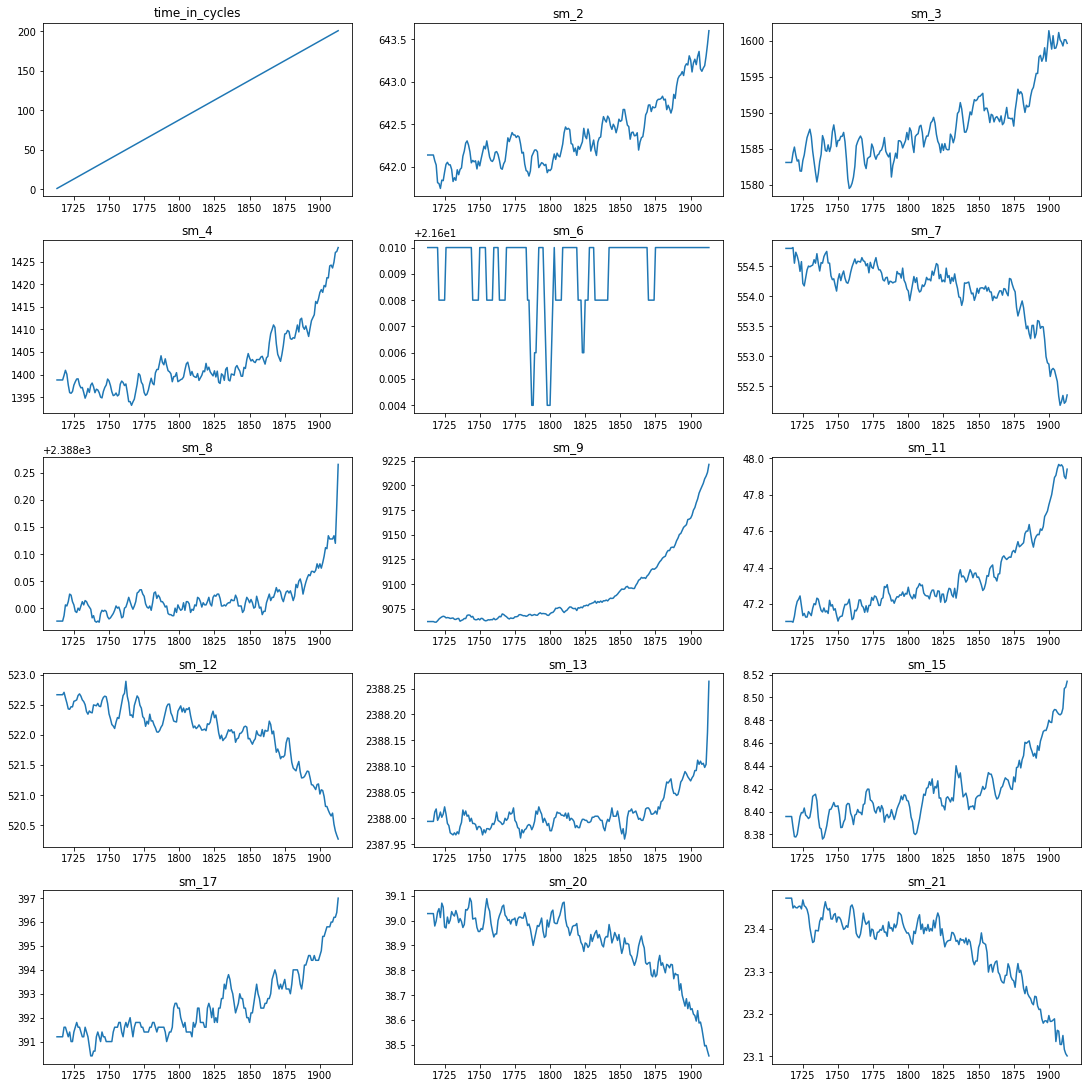

In [18]:
plot_signals(pd.concat([unit_number_train, smooth_train_df], axis=1), features, 9)

In [19]:
X_train = smooth_train_df.iloc[:, :-1].to_numpy()
y_train = smooth_train_df.iloc[:, -1].to_numpy()
print(X_train.shape)
print(y_train.shape)

(20631, 15)
(20631,)


In [20]:
X_test = test_df.to_numpy()
y_test = np.loadtxt(rul_file)
print(X_test.shape)
print(y_test.shape)

(100, 15)
(100,)


### Using Random Forest Regression

In [21]:
random_forest = RandomForestRegressor(n_estimators=100, max_features=7, max_depth=5, n_jobs=-1, random_state=1, criterion='mae')
random_forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=5, max_features=7, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [22]:
y_rf_pred = random_forest.predict(X_test)

In [23]:
score(y_test, y_rf_pred)

Mean absolute error (in cycles) : 17.54
Root mean square error (in cycles) : 23.01
Coefficent of determination : 0.69


In [30]:
joblib.dump(random_forest, os.path.join(weight_path, 'random_forest_smooth.sav'))

['D:\\Projects\\machine_failure\\weights\\random_forest_smooth.sav']

### Using XGBoost Regression

In [24]:
xgb = xgboost.XGBRegressor(n_estimators=110, learning_rate=0.018, gamma=0, subsample=0.8, 
                             colsample_bytree=0.5, max_depth=3,verbosity=1)
xgb.fit(X_train, y_train)

[14:03:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0,
             importance_type='gain', learning_rate=0.018, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=110,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8, verbosity=1)

In [25]:
y_xgb_pred = xgb.predict(X_test)

In [26]:
score(y_test, y_xgb_pred)

Mean absolute error (in cycles) : 14.29
Root mean square error (in cycles) : 19.65
Coefficent of determination : 0.78


In [29]:
joblib.dump(xgb, os.path.join(weight_path, 'xgb_smoothed.sav'))

['D:\\Projects\\machine_failure\\weights\\xgb_smoothed.sav']